# POS Tagger based on CRF

## # Required Modules

In [2]:
import random
from sklearn_crfsuite import CRF
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

In [2]:
from sklearn.metrics import classification_report
import pickle
def save_obj(obj, name ):
    with open(name + '.pkl', 'ab') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        f.close()

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:  
      objs = []
      while 1:
          try:
              x = pickle.load(f)
              objs.append(x)
              for filename in x.keys():
                print(filename, x[filename]['accuracy'],x[filename]['weighted avg'])
          except EOFError:
              break
      
      return objs


## # Dataset loading

In [3]:
def features(sentence, index):
    return {
        'word': sentence[index],
        'is_first': index == 0,
        'is_last': index == len(sentence) - 1,
        'prefix-1': sentence[index][0],
        'prefix-2': sentence[index][:2],
        'prefix-3': sentence[index][:3],
        'suffix-1': sentence[index][-1],
        'suffix-2': sentence[index][-2:],
        'suffix-3': sentence[index][-3:],
        'prev_word': '' if index == 0 else sentence[index - 1],
        'pp_word' : '' if index <= 1 else sentence[index - 2],
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1],
        'nn_word' : '' if index >= len(sentence) - 2 else sentence[index + 2],
        'is_numeric': sentence[index].isdigit()
    }

In [4]:
files_all = ["guj_art and culture_sample1.txt", "guj_economy_sample2.txt", "guj_entertainment_sample3.txt", "guj_philosophy_sample4.txt", "guj_religion_sample5.txt", "guj_science and technology_sample6.txt", "guj_sports_sample7.txt"]
word_sentences = []
tag_sentences = []

files = files_all
# filename = files_all[6].split('.')[0]
filename = "combined"
for file_ in files:
    file = open("./dataset/" + file_, "r")
    contents = file.read().split('\n')

    for i in range(1,len(contents)):
        # s = contents[i][10:]
        s = contents[i].split('\t')[1]
        words = []
        tags = []
        for ss in s.split(' '):
            if len(ss.split('\\')) != 2:
                continue
            word = ss.split('\\')[0]
            tag = ss.split('\\')[1]
            words.append(word)
            tags.append(tag)
        word_sentences.append(words)
        tag_sentences.append(tags)

    file.close()

# X = word_sentences
# Y = tag_sentences
    
X = []
Y = []
for sentence, tags in zip(word_sentences, tag_sentences):
    X.append([features(sentence, index) for index in range(len(sentence))])
    Y.append([tag for tag in tags])
print(X[1])
print(Y[1])

[{'word': 'વર્ષો', 'is_first': True, 'is_last': False, 'prefix-1': 'વ', 'prefix-2': 'વર', 'prefix-3': 'વર્', 'suffix-1': 'ો', 'suffix-2': 'ષો', 'suffix-3': '્ષો', 'prev_word': '', 'pp_word': '', 'next_word': 'પહેલાંની', 'nn_word': 'આ', 'is_numeric': False}, {'word': 'પહેલાંની', 'is_first': False, 'is_last': False, 'prefix-1': 'પ', 'prefix-2': 'પહ', 'prefix-3': 'પહે', 'suffix-1': 'ી', 'suffix-2': 'ની', 'suffix-3': 'ંની', 'prev_word': 'વર્ષો', 'pp_word': '', 'next_word': 'આ', 'nn_word': 'વાત', 'is_numeric': False}, {'word': 'આ', 'is_first': False, 'is_last': False, 'prefix-1': 'આ', 'prefix-2': 'આ', 'prefix-3': 'આ', 'suffix-1': 'આ', 'suffix-2': 'આ', 'suffix-3': 'આ', 'prev_word': 'પહેલાંની', 'pp_word': 'વર્ષો', 'next_word': 'વાત', 'nn_word': 'છે', 'is_numeric': False}, {'word': 'વાત', 'is_first': False, 'is_last': False, 'prefix-1': 'વ', 'prefix-2': 'વા', 'prefix-3': 'વાત', 'suffix-1': 'ત', 'suffix-2': 'ાત', 'suffix-3': 'વાત', 'prev_word': 'આ', 'pp_word': 'પહેલાંની', 'next_word': 'છે', 'nn

## # Split dataset into Train-Test (80%-20%)

In [5]:
indexlist = random.sample(range(0, len(X)), int(len(X)*0.2))

X_test = []
Y_test = []
X_train = []
Y_train = []

for i in range(len(X)):
    if i in indexlist:
        X_test.append(X[i])
        Y_test.append(Y[i])
    else:
        X_train.append(X[i])
        Y_train.append(Y[i])

print('Train len ',len(X_train))
print('Test len ',len(X_test))

Train len  5600
Test len  1400


## # Init CRF Model

In [6]:
crf = CRF(c1 = 1, c2 = 5)

In [7]:
crf.fit(X_train, Y_train)

/home/smit/.local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


CRF(c1=1, c2=5, keep_tempfiles=None)

## # Finding Accuracy Score

In [8]:
def accuracy(tag_sentences_test, test_tag_pred):
    correct_prediction = wrong_prediction = total_predictions = total_word = 0
    passed = 0
    for tag_true, tag_pred in zip(tag_sentences_test, test_tag_pred):
        for pred, actual in zip(tag_pred, tag_true):
            if pred == actual:
                correct_prediction += 1
            else:
                wrong_prediction += 1
            total_predictions += 1
    
    print('Correct pred ', correct_prediction)
    print('Wrong pred ', wrong_prediction)
    print('Total word ', total_predictions)
    return correct_prediction / total_predictions
 
# X1, Y1 = X_train, Y_train  # train
X1, Y1 = X_test, Y_test    # test
Y_pred = crf.predict(X1)
print("accuracy score :", round(accuracy(Y1, Y_pred),4))

Correct pred  17061
Wrong pred  2192
Total word  19253
accuracy score : 0.8861


In [9]:
true = []
for labels in Y_test:
    true.extend(labels)

pred = []
for labels in Y_pred:
    pred.extend(labels)

## # Saving the results

In [133]:
report = (classification_report(true, pred,output_dict=True))
output = {}
output[filename] = report
print(output)
save_obj(output, 'CRF_report')

{'combined': {'CC_CCD': {'precision': 0.9561068702290076, 'recall': 0.9506641366223909, 'f1-score': 0.9533777354900096, 'support': 527}, 'CC_CCS': {'precision': 0.9398907103825137, 'recall': 0.9828571428571429, 'f1-score': 0.9608938547486033, 'support': 175}, 'CC_CCS_UT': {'precision': 0.875, 'recall': 0.5384615384615384, 'f1-score': 0.6666666666666667, 'support': 13}, 'DM_DMD': {'precision': 0.8728323699421965, 'recall': 0.9602543720190779, 'f1-score': 0.9144587433762301, 'support': 629}, 'DM_DMI': {'precision': 0.875, 'recall': 0.9459459459459459, 'f1-score': 0.9090909090909091, 'support': 74}, 'DM_DMQ': {'precision': 0.7647058823529411, 'recall': 1.0, 'f1-score': 0.8666666666666666, 'support': 13}, 'DM_DMR': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}, 'JJ': {'precision': 0.827922077922078, 'recall': 0.7746835443037975, 'f1-score': 0.8004185194873137, 'support': 1975}, 'N_NN': {'precision': 0.8166847910517322, 'recall': 0.9421146953405017, 'f1-score': 0.87492718

In [134]:
x = load_obj('CRF_report')

guj_art and culture_sample1 0.843960269144505 {'precision': 0.8452150397949051, 'recall': 0.843960269144505, 'f1-score': 0.8381100419060992, 'support': 3121}
guj_economy_sample2 0.8937007874015748 {'precision': 0.8969172005124546, 'recall': 0.8937007874015748, 'f1-score': 0.8901043182699567, 'support': 2540}
guj_entertainment_sample3 0.8337696335078534 {'precision': 0.839839765990358, 'recall': 0.8337696335078534, 'f1-score': 0.829100949526107, 'support': 2292}
guj_philosophy_sample4 0.8623853211009175 {'precision': 0.8638807435563749, 'recall': 0.8623853211009175, 'f1-score': 0.8578786684976536, 'support': 2725}
guj_religion_sample5 0.8227091633466136 {'precision': 0.8409961164421174, 'recall': 0.8227091633466136, 'f1-score': 0.8190889675336573, 'support': 2510}
guj_science and technology_sample6 0.848502994011976 {'precision': 0.8518680799934226, 'recall': 0.848502994011976, 'f1-score': 0.8418135964497269, 'support': 3340}
guj_sports_sample7 0.85137861466039 {'precision': 0.854236711

## # Confusion Matrix

['CC_CCD', 'CC_CCS', 'CC_CCS_UT', 'DM_DMD', 'DM_DMI', 'DM_DMQ', 'DM_DMR', 'JJ', 'N_NN', 'N_NNP', 'N_NST', 'PR_PRC', 'PR_PRF', 'PR_PRI', 'PR_PRL', 'PR_PRP', 'PR_PRQ', 'PSP', 'QT_QTC', 'QT_QTF', 'QT_QTO', 'RB', 'RD_ECH', 'RD_PUNC', 'RD_RDF', 'RD_SYM', 'RP_CL', 'RP_INJ', 'RP_INTF', 'RP_NEG', 'RP_RPD', 'V_VAUX', 'V_VAUX_VNP', 'V_VM']
Confusion matrix, without normalization


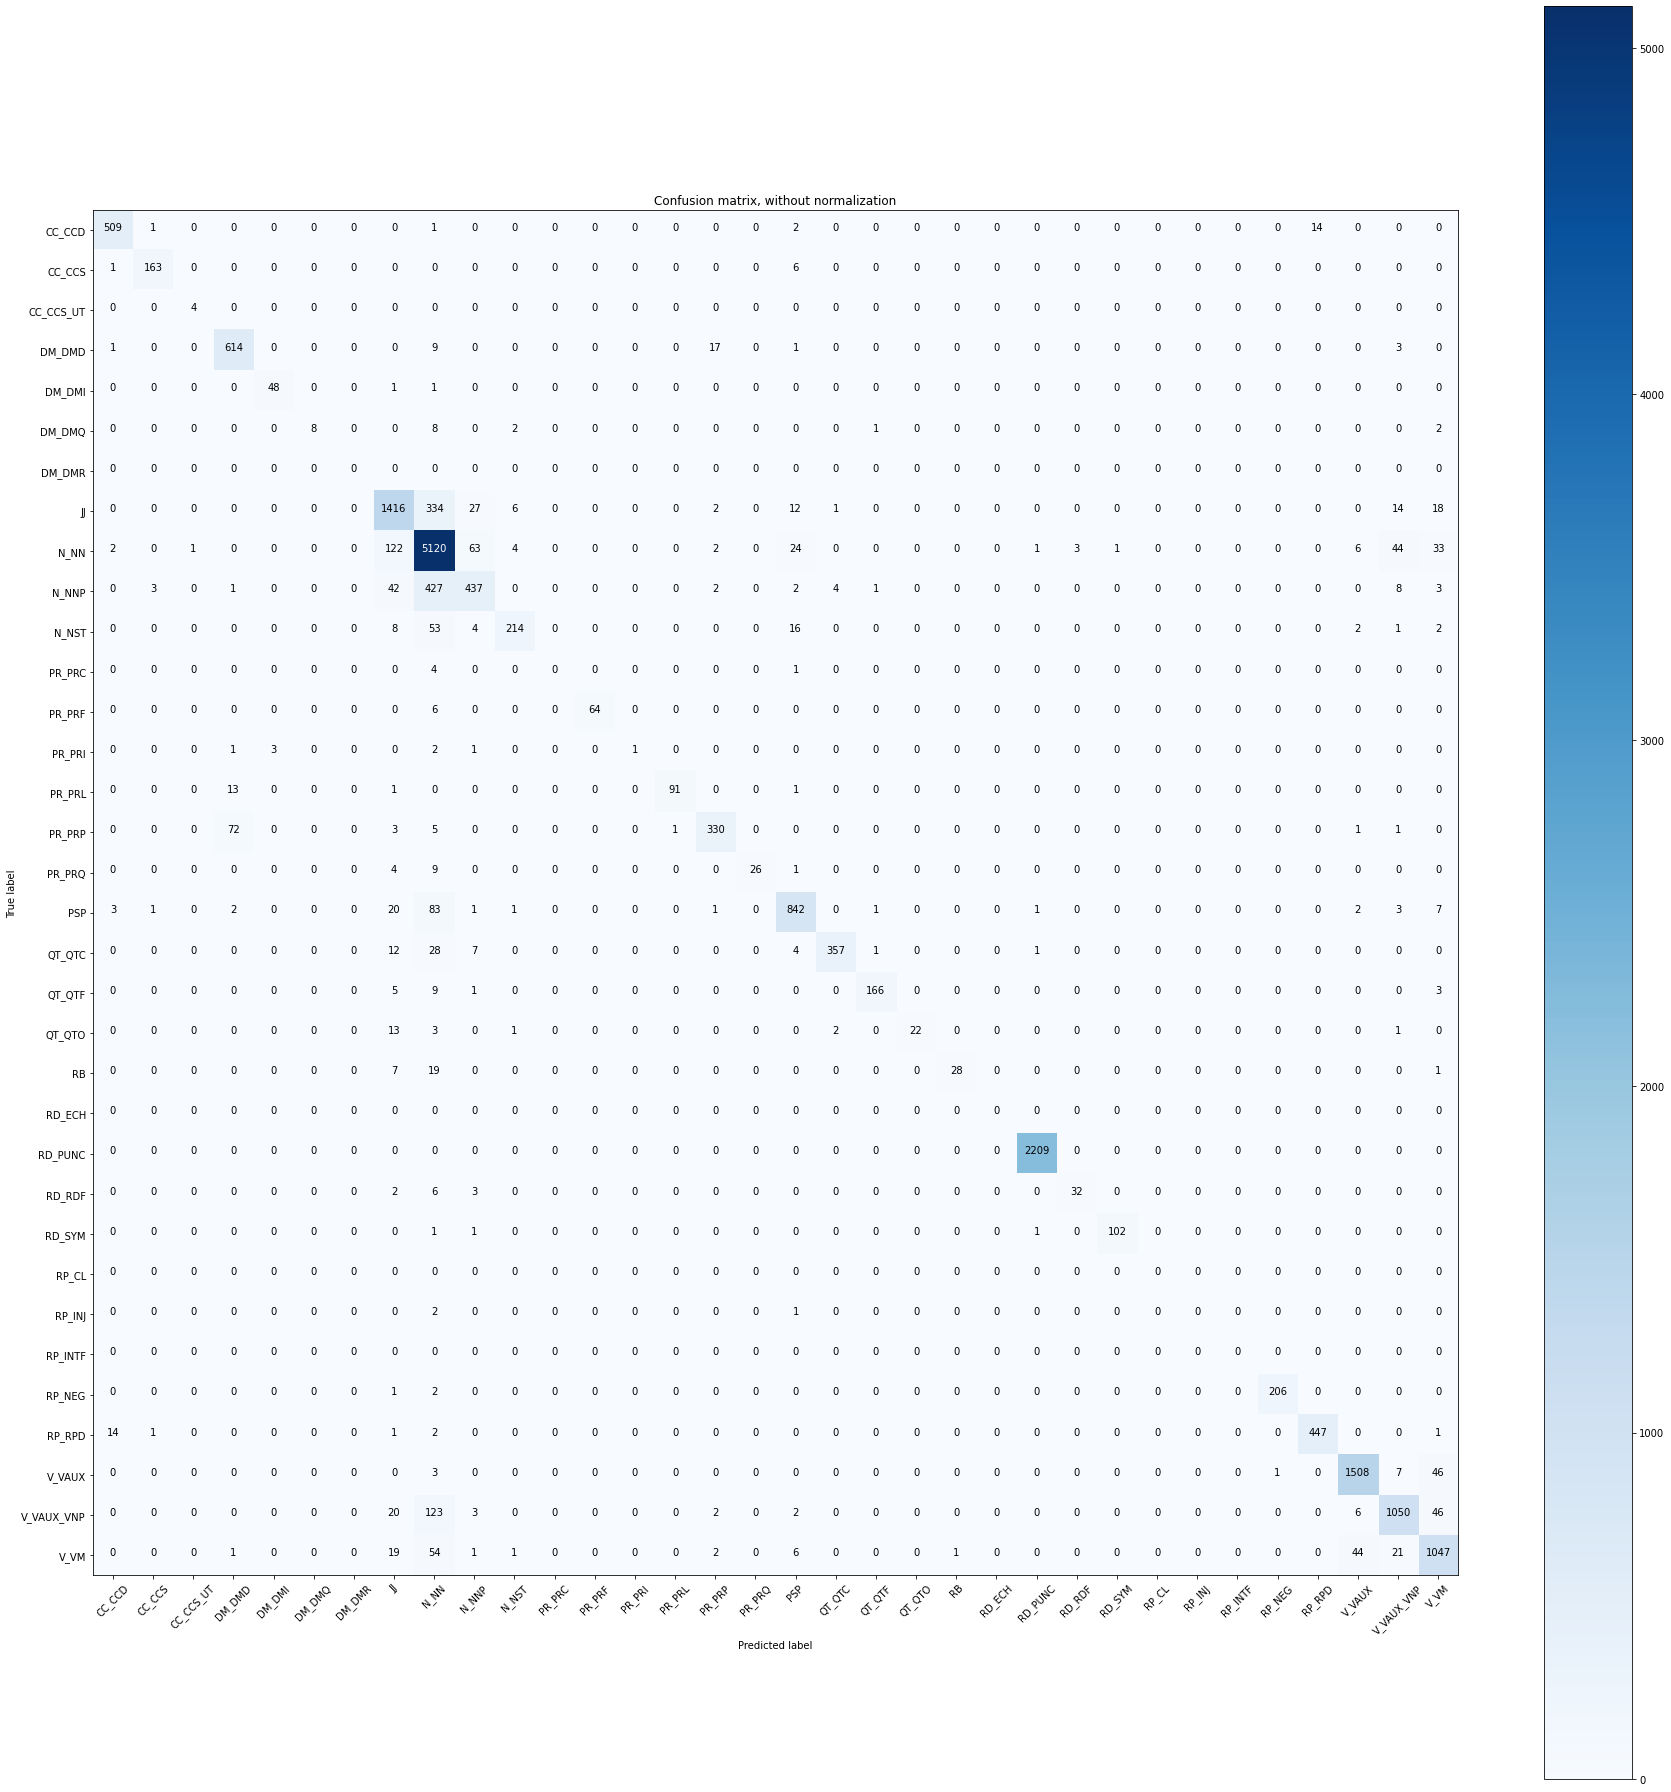

In [16]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    # plt.figure(figsize=(25, 25))
    np.set_printoptions(precision=2)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
class_names = []
for labels in Y:
    class_names.extend(labels)

class_names = list(set(class_names))
class_names = sorted(class_names)
print(class_names)

cnf_matrix = confusion_matrix(true, pred,labels=class_names)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plt.rcParams["figure.figsize"] = (30, 30)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
# plt.figure()
# plt.rcParams["figure.figsize"] = (15,15)
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

# plt.show()

## # Results comparisions

### # Accuracy Score: CRF (Without Features)
| Dataset | Train Data Accuracy | Test Data Accuracy |
| --- | --- | --- |
| guj_art and culture_sample1.txt | 0.7455 | 0.7217 |
| guj_economy_sample2.txt | 0.8154 | 0.7876 |
| guj_entertainment_sample3.txt | 0.7572 | 0.7016 |
| guj_philosophy_sample4.txt | 0.7877 | 0.7527 |
| guj_religion_sample5.txt | 0.7494 | 0.7235 |
| guj_science and technology_sample6.txt | 0.7335 | 0.7088 |
| guj_sports_sample7.txt | 0.7331 | 0.7089 |

### # Accuracy Score: CRF (With Features)
| Dataset | Train Data Accuracy | Test Data Accuracy |
| --- | --- | --- |
| guj_art and culture_sample1.txt | 0.9995 | 0.8439 |
| guj_economy_sample2.txt | 0.9996 | 0.8937 |
| guj_entertainment_sample3.txt | 0.9996 | 0.8337 |
| guj_philosophy_sample4.txt | 0.9997 | 0.8623 |
| guj_religion_sample5.txt | 0.9992 | 0.8227 |
| guj_science and technology_sample6.txt | 0.9998 | 0.8485 |
| guj_sports_sample7.txt | 0.9991 | 0.8513 |


### # Accuracy Score: HMM
| Dataset | Train Data Accuracy | Test Data Accuracy |
| --- | --- | --- |
| guj_art and culture_sample1.txt | 0.9801 | 0.7413 |
| guj_economy_sample2.txt | 0.9884 | 0.9061 |
| guj_entertainment_sample3.txt | 0.9716 | 0.7680 |
| guj_philosophy_sample4.txt | 0.9866 | 0.8674 |
| guj_religion_sample5.txt | 0.9770 | 0.7100 |
| guj_science and technology_sample6.txt | 0.9810 | 0.8532 |
| guj_sports_sample7.txt | 0.9753 | 0.7824 |

### # Dataset Details
| Index | Dataset | Size (No. of sentences) |  Size (No. of words) | Train (No. of sentences) | Test (No. of sentences) |
| --- | --- | --- | --- | --- | --- |
| D1 | guj_art and culture_sample1.txt | 1000 | 16050 | 800 | 200 |
| D2 | guj_economy_sample2.txt | 1000 | 12467 | 800 | 200 |
| D3 | guj_entertainment_sample3.txt | 1000 | 11879 | 800 | 200 |
| D4 | guj_philosophy_sample4.txt | 1000 | 12904 | 800 | 200 |
| D5 | guj_religion_sample5.txt | 1000 | 12247 | 800 | 200 |
| D6 | guj_science and technology_sample6.txt | 1000 | 16857 | 800 | 200 |
| D7 | guj_sports_sample7.txt | 1000 | 14836 | 800 | 200 |

| Topics | Size (No. of sentences) |  Size (No. of words) |
| --- | --- | --- |
| Art and Culture | 1000 | 16050 |
| Economy | 1000 | 12467 |
| Entertainment | 1000 | 11879 |
| Philosophy | 1000 | 12904 |
| Religion | 1000 | 12247 |
| Science and Technology | 1000 | 16857 |
| Sports | 1000 | 14836 |
| Total | 7000 | 97240 |

In [1]:
dataset = ["D1", "D2", "D3", "D4", "D5", "D6", "D7"]

train_acc_crf_wof = [0.7455, 0.8154, 0.7572, 0.7877, 0.7494, 0.7335, 0.7331]
test_acc_crf_wof = [0.7217, 0.7876, 0.7016, 0.7527, 0.7235, 0.7088, 0.7089]

train_acc_crf_wf = [0.9995, 0.9996, 0.9996, 0.9997, 0.9992, 0.9998, 0.9991]
test_acc_crf_wf = [0.8439, 0.8937, 0.8337, 0.8623, 0.8227, 0.8485, 0.8513]

train_acc_hmm = [0.9801, 0.9884, 0.9716, 0.9866, 0.9770, 0.9810, 0.9753]
test_acc_hmm = [0.7413, 0.9061, 0.7680, 0.8674, 0.7100, 0.8532, 0.7824]

### # CRF: Train Acc. v/s Test Acc.

#### # Without Features

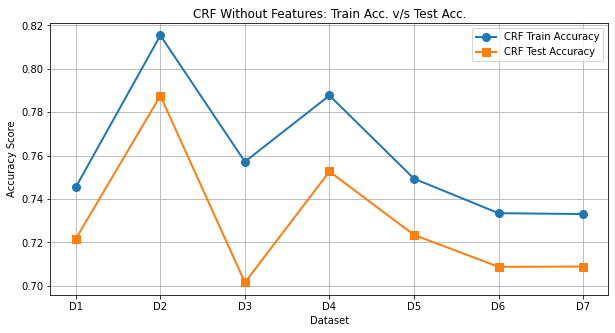

In [3]:
plt.figure(figsize=(10, 5))
plt.plot(dataset, train_acc_crf_wof, label = "CRF Train Accuracy", linewidth = 2, marker = 'o', markersize = 8) 
plt.plot(dataset, test_acc_crf_wof, label = "CRF Test Accuracy", linewidth = 2, marker = 's', markersize = 8) 
plt.title('CRF Without Features: Train Acc. v/s Test Acc.') 
plt.xlabel("Dataset")
plt.ylabel("Accuracy Score")
plt.legend()
plt.grid()
plt.show()

#### # With Features

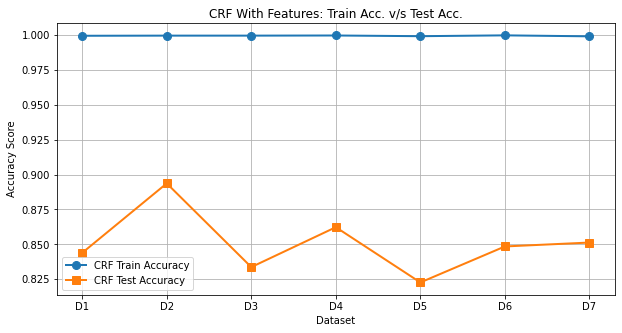

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(dataset, train_acc_crf_wf, label = "CRF Train Accuracy", linewidth = 2, marker = 'o', markersize = 8) 
plt.plot(dataset, test_acc_crf_wf, label = "CRF Test Accuracy", linewidth = 2, marker = 's', markersize = 8) 
plt.title('CRF With Features: Train Acc. v/s Test Acc.') 
plt.xlabel("Dataset")
plt.ylabel("Accuracy Score")
plt.legend()
plt.grid()
plt.show()

### # HMM: Train Acc. v/s Test Acc.

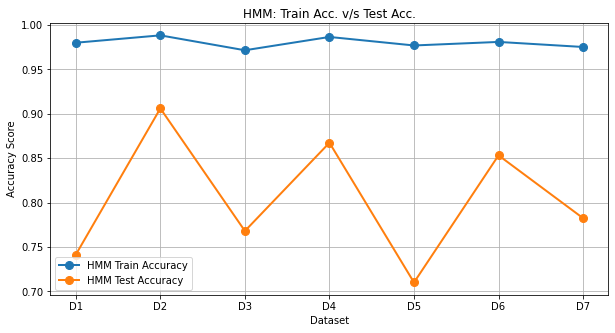

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(dataset, train_acc_hmm, label = "HMM Train Accuracy", linewidth = 2, marker = 'o', markersize = 8) 
plt.plot(dataset, test_acc_hmm, label = "HMM Test Accuracy", linewidth = 2, marker = 'o', markersize = 8) 
plt.title('HMM: Train Acc. v/s Test Acc.') 
plt.xlabel("Dataset")
plt.ylabel("Accuracy Score")
plt.legend()
plt.grid()
plt.show()

### # HMM Train Acc. v/s CRF With Features Train Acc.

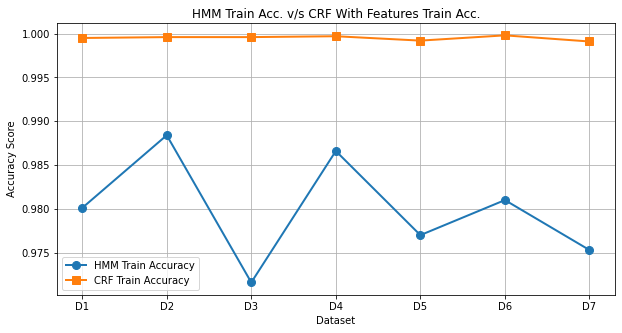

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(dataset, train_acc_hmm, label = "HMM Train Accuracy", linewidth = 2, marker = 'o', markersize = 8) 
plt.plot(dataset, train_acc_crf_wf, label = "CRF Train Accuracy", linewidth = 2, marker = 's', markersize = 8) 
plt.title('HMM Train Acc. v/s CRF With Features Train Acc.') 
plt.xlabel("Dataset")
plt.ylabel("Accuracy Score")
plt.legend()
plt.grid()
plt.show()

### # HMM Test Acc. v/s CRF With Features Test Acc.

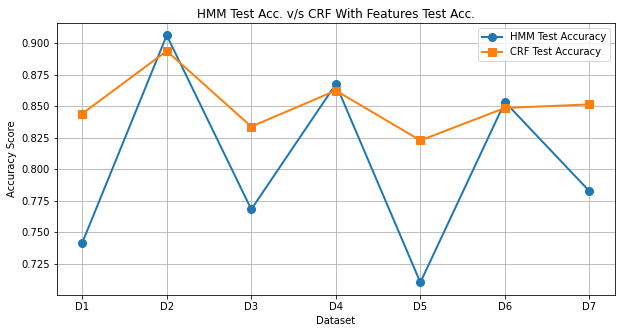

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(dataset, test_acc_hmm, label = "HMM Test Accuracy", linewidth = 2, marker = 'o', markersize = 8) 
plt.plot(dataset, test_acc_crf_wf, label = "CRF Test Accuracy", linewidth = 2, marker = 's', markersize = 8) 
plt.title('HMM Test Acc. v/s CRF With Features Test Acc.') 
plt.xlabel("Dataset")
plt.ylabel("Accuracy Score")
plt.legend()
plt.grid()
plt.show()